
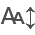

In [1]:
import pandas as pd
from itables import init_notebook_mode
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

init_notebook_mode(all_interactive=True)

Let's first load the data of the three students with some error handling in case the data structures or something else has changed

In [2]:
# Definition of the file details in a dictionary
file_details = {
    'StudentA': {'path': '../Group8__ImholzA_AntonB_GonzalezC/Imholz_Chris_studentA/Data/Imholz_Chris_studentA_stage3.csv', 'sep': ';', 'on_bad_lines': 'skip'},
    'StudentB': {'path': '../Group8__ImholzA_AntonB_GonzalezC/Anton_Victor_studentB/Data/stage3/Anton_Victor_studentB_stage3.csv', 'sep': ';'},
    'StudentC': {'path': '../Group8__ImholzA_AntonB_GonzalezC/Gonzalez_Rodrigo_studentC/Data/GonzalezAlonso_Rodrigo_studentC_stage3.csv', 'sep': ','}}

# Initialize an empty dictionary to store the three DataFrames
dfs = {}

# Load the data with error handling
for student, details in file_details.items():

    try:
        dfs[student] = pd.read_csv(details['path'], sep=details.get('sep', ','), on_bad_lines=details.get('on_bad_lines', 'error'))
        print(f"{student} data loaded successfully!")

    except Exception as e:
        print(f"An error occurred while loading {student} data: {e}")

# If you need to use the DataFrames individually later on:
df_studentA = dfs.get('StudentA')
df_studentB = dfs.get('StudentB')
df_studentC = dfs.get('StudentC')

StudentA data loaded successfully!
StudentB data loaded successfully!
StudentC data loaded successfully!


Let's proceed to merge the previously loaded files

In [5]:
try:
    # Merge dataframes on specified keys with inner join
    df = pd.merge(df_studentA, df_studentC, left_on='ISIN Code', right_on='ISIN', how='inner')
    df = pd.merge(df, df_studentB, left_on='TICKER', right_on='Ticker', how='inner')
    df.columns = df.columns.str.title()  # Standardize column headers to title case

    # Print the shape of individual and merged dataframes
    print(f"The CSV 'Imholz_Chris_studentA_stage3.csv' has {df_studentA.shape[0]} rows and {df_studentA.shape[1]} columns.")
    print(f"The CSV 'Anton_Victor_studentB_stage3.csv' has {df_studentB.shape[0]} rows and {df_studentB.shape[1]} columns.")
    print(f"The CSV 'GonzalezAlonso_Rodrigo_studentC_stage3.csv' has {df_studentC.shape[0]} rows and {df_studentC.shape[1]} columns.")
    print(f"The merged dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

    # Check if merged dataframe has more rows than any individual dataframe
    if df.shape[0] > max(df_studentA.shape[0], df_studentB.shape[0], df_studentC.shape[0]):
        print("\033[1;31m!!! The merged dataframe has more rows than any of the individual source files, which may indicate duplicate entries or errors in merging.\033[0m") # Prints error in bold red, warns of possible data issues.
    elif df.shape[0] < min(df_studentA.shape[0], df_studentB.shape[0], df_studentC.shape[0]):
        print("\033[1;31m!!! The merged dataframe has fewer rows than all individual source files, which may indicate data loss during merging.\033[0m") # Prints error in bold red, warns of possible data issues.
    else:
        print("The merged dataframe seems to have worked correctly and aligns with expected row counts from individual files.")

except Exception as e:
    print(f"An error occurred: {e}")


The CSV 'Imholz_Chris_studentA_stage3.csv' has 187 rows and 22 columns.
The CSV 'Anton_Victor_studentB_stage3.csv' has 196 rows and 3 columns.
The CSV 'GonzalezAlonso_Rodrigo_studentC_stage3.csv' has 194 rows and 12 columns.
The merged dataframe has 227 rows and 37 columns.
!!! The merged dataframe has more rows than any of the individual source files, which may indicate duplicate entries or errors in merging.


In [6]:
df.head()

Name Currency   Type         Sub Type              Market  \
0             ACCOR      EUR  Stock  Ordinary Shares      Euronext Paris   
1       AIR LIQUIDE      EUR  Stock  Ordinary Shares      Euronext Paris   
2         AIRBUS SE      EUR  Stock  Ordinary Shares      Euronext Paris   
3  ARCELORMITTAL SA      EUR  Stock  Ordinary Shares  Euronext Amsterdam   
4  ARCELORMITTAL SA      EUR  Stock  Ordinary Shares  Euronext Amsterdam   

      Isin Code                    Industry  \
0  FR0000120404  40, Consumer Discretionary   
1  FR0000120073         55, Basic Materials   
2  NL0000235190             50, Industrials   
3  LU1598757687         55, Basic Materials   
4  LU1598757687         55, Basic Materials   

                           Supersector                                Sector  \
0             4050, Travel and Leisure            405010, Travel and Leisure   
1                      5520, Chemicals                     552010, Chemicals   
2  5020, Industrial Goods and Services         502010, Aerospace and Defense   
3                5510, Basic Resources  551020, Industrial Metals and Mining   
4                5510, Basic Resources  551020, Industrial Metals and Mining   

                       Subsector  ...      Turnover  Turnover In Eur  \
0    40501025, Hotels and Motels  ...  4.412293e+07     4.412293e+07   
1  55201020, Specialty Chemicals  ...  1.176671e+08     1.176671e+08   
2            50201010, Aerospace  ...  1.657425e+08     1.657425e+08   
3       55102010, Iron and Steel  ...  4.432131e+07     4.432131e+07   
4       55102010, Iron and Steel  ...  4.432131e+07     4.432131e+07   

      Volume  Roa   Roe  Roic  Ccy   Index  \
0  1016775.0  4.0  11.9   8.0  EUR  CAC_40   
1   609693.0  6.1  12.9  12.1  EUR  CAC_40   
2   969451.0  2.3  23.5  13.5  EUR  CAC_40   
3  1738641.0  2.1   1.8   4.5  EUR  CAC_40   
4  1738641.0  2.1   1.8   4.5  EUR  CAC_40   

                                           Component  Ticker  
0                                           ACCOR SA      AC  
1  L'AIR LIQUIDE SOCIETE ANONYME POUR L'ETUDE ET ...      AI  
2                                          AIRBUS SE    1AIR  
3                                   ARCELORMITTAL SA      MT  
4                                   ARCELORMITTAL SA      MT  

[5 rows x 37 columns]

**Ops! There are duplicates from the merge! lets handle it**

In [7]:
# Calculate and print the frequency of each unique name in the 'Name' column.
name_counts = df['Name'].value_counts()
print(name_counts)

Name
STMICROELECTRONICS    32
ARCELORMITTAL SA       8
GENERALI ASS           2
STELLANTIS NV          2
STELLANTIS             2
                      ..
ACKERMANS V.HAAREN     1
AEDIFICA               1
AGEAS                  1
ARGENX SE              1
UNIPOL                 1
Name: count, Length: 185, dtype: int64


In [8]:
# Remove any duplicate names, keeping only the first occurrence.
df = df.drop_duplicates(subset='Name', keep='first')

# Count how many times each name appears, which should now be once for each.
name_counts = df['Name'].value_counts()

# Print the counts of each name.
print(name_counts)

Name
ACCOR                    1
AKER BP                  1
KINGSPAN GROUP PLC       1
MALIN CORPORATION PLC    1
MINCON GROUP PLC         1
                        ..
WOLTERS KLUWER           1
AB INBEV                 1
ACKERMANS V.HAAREN       1
AEDIFICA                 1
UNIPOL                   1
Name: count, Length: 185, dtype: int64


**Let's organize the lines to be able to work more with it, dropping duplicates along the way**

In [9]:
# New column order for the DataFrame.
columns_order = [
    'Name', 'Market Cap In Usd', 'Currency', 'Market', 'Index',
    'Isin Code', 'Turnover In Eur', "Issuer Country", 'Industry', 
    'Supersector', 'Sector', 'Subsector', 
    'Average Training Hours Per Employee', 'Number Of Female Board Members', 
    'Number Of Board Members', 'Share Of Women In Total Workforce In %', 
    'Share Of Women In Management Bodies In %', 'Gender Pay Gap In %', 
    'Rate Of Employees With Disabilities In %', 
    'Board Gender Diversity (Female Board Members / Total Board Members) In %', 
    'Total Energy Consumption In Mwh', 'Rate Of Resignation In %', 
    'Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd', 
    'Roa', 'Roe', 'Roic'
]

# Reorder of the DataFrame columns according to 'columns_order'.
df = df[columns_order]

In [10]:
def format_column_name(name):
    """
    Format the first two words of a name to have capitalized first letters and the rest in lowercase.
    
    Parameters:
    name (str): A string containing the full name to be formatted.

    Returns:
    str: The formatted name string with the first two words capitalized and any subsequent words left as is.

    Description:
    This function takes a name, splits it into words, and formats only the first two words to capitalize
    the initial letter of each, leaving any other words in their original form. The words are then
    joined back into a single string and returned.
    """
    words = name.split()
    formatted_words = [word.capitalize() if i < 2 else word for i, word in enumerate(words)]
    return ' '.join(formatted_words)

# Apply the function 'format_name' to each entry in the 'Name' column of the DataFrame 'df'.
df['Name'] = df['Name'].apply(format_column_name)

# Display the first few rows of the 'Name' column in the DataFrame 'df'
print(df['Name'].head()) # and yes, it works

0                Accor
1          Air Liquide
2            Airbus Se
3     Arcelormittal Sa
11                 Axa
Name: Name, dtype: object


# ESG Indexes | Questions

## Question 1 | Which are the most and less polluting companies listed on Europe's main indexes provided by Euronext regarding its size measured by sales volume and market capitalization?  



The first research question of our study aims to develop a detailed understanding of which companies listed on Euronext's main indices contribute the most and least to pollution relative to their size in terms of sales volume and market capitalisation. Only companies that provided complete information on the following details were included in the analysis:

Relevant columns are
- **Name:** Company name
- **Market Cap** Market capitalization
- **Turnover In Eur:** Annual sales volume in Euros
- **Total Energy Consumption In Mwh:** Total energy usage in Megawatt-hours
- **Carbon footprint (total GHG emissions / enterprise value)_in_USD:** Carbon footprint relative to the enterprise value in USD

In [11]:
# Filter relevant columns
df_pollution = df.copy()
df_pollution = df[['Name', 'Market Cap In Usd', 'Turnover In Eur', 'Total Energy Consumption In Mwh', 
                    'Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd', 'Subsector']]

# Filter to get only the rows with zero values
rows_with_na = df_pollution[df_pollution.isnull().any(axis=1)]

# Extract the names from the empty columns and print the name of the excluded companies
companys_with_na = rows_with_na['Name'].tolist()
print("Amount of excluded companys due to missing data:", len(companys_with_na))
print("Excluded companies:", companys_with_na)

# Handle missing values by dropping rows with any missing data
df_pollution.dropna(inplace=True)

Amount of excluded companys due to missing data: 97
Excluded companies: ['Air Liquide', 'Airbus Se', 'Bnp Paribas ACT.A', 'Bouygues', 'Carrefour', 'Credit Agricole', 'Danone', 'Hermes Intl', 'Michelin', 'Orange', 'Safran', 'Sanofi', 'Societe Generale', 'Thales', 'Abn Amro BANK N.V.', 'Adyen', 'Koninklijke Ahold DELHAIZE N.V.', 'Akzo Nobel', 'Asm International N.V.', 'Asr Nederland', 'Dsm Firmenich AG', 'Exor', 'Ing Groep N.V.', 'Kon.philips N.v.', 'Randstad N.v.', 'Universal Music GROUP', 'Unilever Plc', 'Wolters Kluwer', 'Ackermans V.haaren', 'Aedifica', 'Ageas', 'Argenx Se', 'Elia Group', 'Gbl', 'Kbc', 'Lotus Bakeries', 'Melexis', 'Sofina', 'Syensqo', 'B.c.p.-bco Comercial PORTUGUES', 'Galp Energia-nom', 'Ibersol-sgps', 'Semapa', 'Aib Group PLC', 'Bank Of IRELAND GROUP PLC', 'Cairn Homes PLC', 'Corre Energy B.V.', 'Crh Plc', 'Datalex Plc', 'Donegal Investment GROUP PLC', 'Fbd Holdings PLC', 'Fd Technologies PLC', 'Glanbia Plc', 'Glenveagh Properties PLC', 'Great Western MINING CORPOR

C:\Users\Victor\AppData\Local\Temp\ipykernel_10204\997153569.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pollution.dropna(inplace=True)


In [12]:
# Sortieren des DataFrames nach dem Carbon Footprint in absteigender Reihenfolge
df_sorted = df_pollution.sort_values(by='Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd', ascending=False)

df_sorted.drop_duplicates(subset='Name', keep='first', inplace=True)

# Auswahl der Top 5 und Bottom 5 Unternehmen
top5 = df_sorted.head(5)
bottom5 = df_sorted.tail(5)

# Zusammenführen der Top 5 und Bottom 5 für das Plotting
result_df = pd.concat([top5, bottom5])

# Erstellen des Bar-Charts
fig = px.bar(result_df, x='Name', y='Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd',
             title='Top and Bottom 5 Companies by Carbon Footprint (Total Ghg Emissions / Enterprise Value) In Usd',
             labels={'Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd': 'Carbon Footprint per EV (USD)',
                     'Name': 'Company Name'},
             text='Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd',
             color='Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd',
             color_continuous_scale=px.colors.diverging.Tealrose,
             category_orders={"Name": list(top5['Name']) + list(bottom5['Name'][::-1])})  # This ensures the companies are ordered correctly in the bar chart

# Update layout to adjust visual elements
fig.update_layout(xaxis_title="Company Name",
                  yaxis_title="Carbon Footprint per Enterprise Value (USD)",
                  coloraxis_colorbar=dict(title="Carbon Footprint"),
                  yaxis_type="log")  # Log scale for better visualization if needed

# Show plot
fig.show()

The chart shows a ranking of companies based on their carbon footprint in relation to their enterprise value, measured in US dollars. It is a combined bar chart with logarithmic scaling, showing the five companies with the highest carbon footprint (on the left, marked in pink) and the five companies with the lowest (on the right, marked in different shades of blue).

On the Y-axis, the 'Carbon Footprint per Enterprise Value (USD)' is plotted, which varies over a wide range from 0.01 to over 10,000 USD. The X-axis lists the names of the respective companies.
The company with the highest carbon footprint per enterprise value is "ORIGIN ENTERPRISES PLC" with a very high value compared to the other companies listed. On the other side of the spectrum are companies such as "NOS, SGPS, SA" and "PROSUS", which have a very low carbon footprint per enterprise value.

The realisation from this illustration could be that the range in carbon footprint varies considerably between different companies. The company "ORIGIN ENTERPRISES PLC" could be seen as a significantly higher environmental risk or a company that is not efficient in its use of resources, compared to "PROSUS", which has a lower environmental impact as measured by the ratio of greenhouse gas emissions to enterprise value.

In [13]:
# Plot 2: Turnover vs. Carbon Footprint
fig2 = px.scatter(df_pollution, x='Turnover In Eur', y='Total Energy Consumption In Mwh', 
                  hover_name='Name', 
                  title='Turnover vs. Carbon Footprint',
                  labels={'Turnover In Eur': 'Turnover (USD)', 
                          'Carbon Footprint per EV USD': 'Carbon Footprint per EV (USD)'},
                   hover_data={'Subsector': True},)
fig2.update_layout(xaxis_type="linear", yaxis_type="linear",
                   xaxis_title="Turnover (USD)",
                   yaxis_title="Total Energy Consumption In Mwh")
fig2.show()

The image shows a scatter plot with the heading "Turnover vs. carbon footprint". The X-axis represents the turnover of the companies in USD, from 0 to 500 million USD, while the Y-axis shows the total energy consumption in megawatt hours (MWh), ranging from 0 to over 600 million MWh.

The points in the chart show the distribution of the individual companies in terms of these two metrics. Some points are grouped close to the Y-axis, indicating companies that have a low turnover but relatively high energy consumption. Others are spread across the entire width of the X-axis, indicating a wide variation in turnover.

The takeaway from this chart could be that there is no clear correlation between a company's turnover and its energy consumption; companies with similar turnover can consume very different amounts of energy. 

In [14]:
# Berechnen von Energy per Euro Turnover
df_pollution['Energy per Euro Turnover (MWh/EUR)'] = (df_pollution['Total Energy Consumption In Mwh'] / df_pollution['Turnover In Eur']).round(5)

# Sortieren des DataFrames nach dem neu berechneten Energy per Euro Turnover in absteigender Reihenfolge
df_sorted = df_pollution.sort_values(by='Energy per Euro Turnover (MWh/EUR)', ascending=False)

# Entfernen von Duplikaten, falls vorhanden
df_sorted.drop_duplicates(subset='Name', keep='first', inplace=True)

# Auswahl der Top 5 und Bottom 5 Unternehmen basierend auf Energy per Euro Turnover
top5 = df_sorted.head(5)
bottom5 = df_sorted.tail(5)

# Zusammenführen der Top 5 und Bottom 5 für das Plotting
result_df2 = pd.concat([top5, bottom5])

# Erstellen des Bar-Charts
fig = px.bar(result_df2, x='Name', y='Energy per Euro Turnover (MWh/EUR)',
             title='Top and Bottom 5 Companies by Energy per Euro Turnover',
             labels={'Energy per Euro Turnover (MWh/EUR)': 'Energy per Euro Turnover (MWh/EUR)',
                     'Name': 'Company Name'},
             text='Energy per Euro Turnover (MWh/EUR)',
             color='Energy per Euro Turnover (MWh/EUR)',
             hover_data={'Subsector': True},
             color_continuous_scale=px.colors.diverging.Tealrose,
             category_orders={"Name": list(top5['Name']) + list(bottom5['Name'][::-1])})  # This ensures the companies are ordered correctly in the bar chart


# Update layout to adjust visual elements
fig.update_layout(xaxis_title="Company Name" ,
                  yaxis_title="Energy per Euro Turnover (MWh/EUR)",
                  coloraxis_colorbar=dict(title="Energy Usage"),
                  yaxis_type="log")  # Log scale for better visualization if needed

# Show plot
fig.show()

C:\Users\Victor\AppData\Local\Temp\ipykernel_10204\1368015395.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Following on from the scatter diagram, which shows no clear correlation between turnover and energy consumption of the companies, the second image offers another revealing perspective: a bar chart entitled "Top and Bottom 5 Companies by Energy per Euro Turnover". Here, energy consumption is set in relation to turnover, expressed in megawatt hours (MWh) per euro of turnover. The logarithmic scaling of the Y-axis ranges from 100 micro-MWh/EUR to 100 MWh/EUR and thus illustrates significant differences in the efficiency with which companies convert their energy into turnover.

The five companies with the highest energy consumption per euro of turnover are represented by bars on the left-hand side, with "CTT-Correios de Portugal, SA" standing out with a value of 115.86042 MWh/EUR. This indicates that this company requires a large amount of energy to generate one euro of turnover - a possible indicator of low energy efficiency. In contrast, the bars on the right show the five companies with the lowest energy consumption per euro of turnover. "ASML Holding", with a value close to 0, demonstrates exceptionally high efficiency in energy use in relation to turnover.

This visual analysis suggests that some companies operate much more efficiently by using less energy to achieve their turnover.

## Question 1 | Conclusion

The study reveals a wide range in the ratio of carbon footprint to company value and shows that companies' turnover and energy consumption do not necessarily correlate. Some companies require a disproportionate amount of energy for their turnover, while others manage with surprisingly little. 

## Question 2 | What is the Euronext Index with components that perform best in terms of environmental and social responsibility?

This question aims to identify the leading index by examining various indicators, including **Carbon Footprint**, **Energy Consumption**, **the Percentage of Women in the Total Workforce and in Management Positions**, **the Gender Pay Gap**, and **the Employment Rate of Individuals with Disabilities**. 


In [20]:
df_final = df.copy()

print(df_final.head())


                Name  Market Cap In Usd Currency              Market   Index  \
0              Accor       1.033192e+10      EUR      Euronext Paris  CAC_40   
1        Air Liquide       1.051361e+11      EUR      Euronext Paris  CAC_40   
2          Airbus Se       1.361650e+11      EUR      Euronext Paris  CAC_40   
3   Arcelormittal Sa       2.175417e+10      EUR  Euronext Amsterdam  CAC_40   
11               Axa       8.254087e+10      EUR      Euronext Paris  CAC_40   

       Isin Code  Turnover In Eur Issuer Country                    Industry  \
0   FR0000120404     4.412293e+07         France  40, Consumer Discretionary   
1   FR0000120073     1.176671e+08         France         55, Basic Materials   
2   NL0000235190     1.657425e+08    Netherlands             50, Industrials   
3   LU1598757687     4.432131e+07     Luxembourg         55, Basic Materials   
11  FR0000120628     1.214798e+08         France              30, Financials   

                            Supersecto

### Energy Consumption and Carbon Footprint by Index

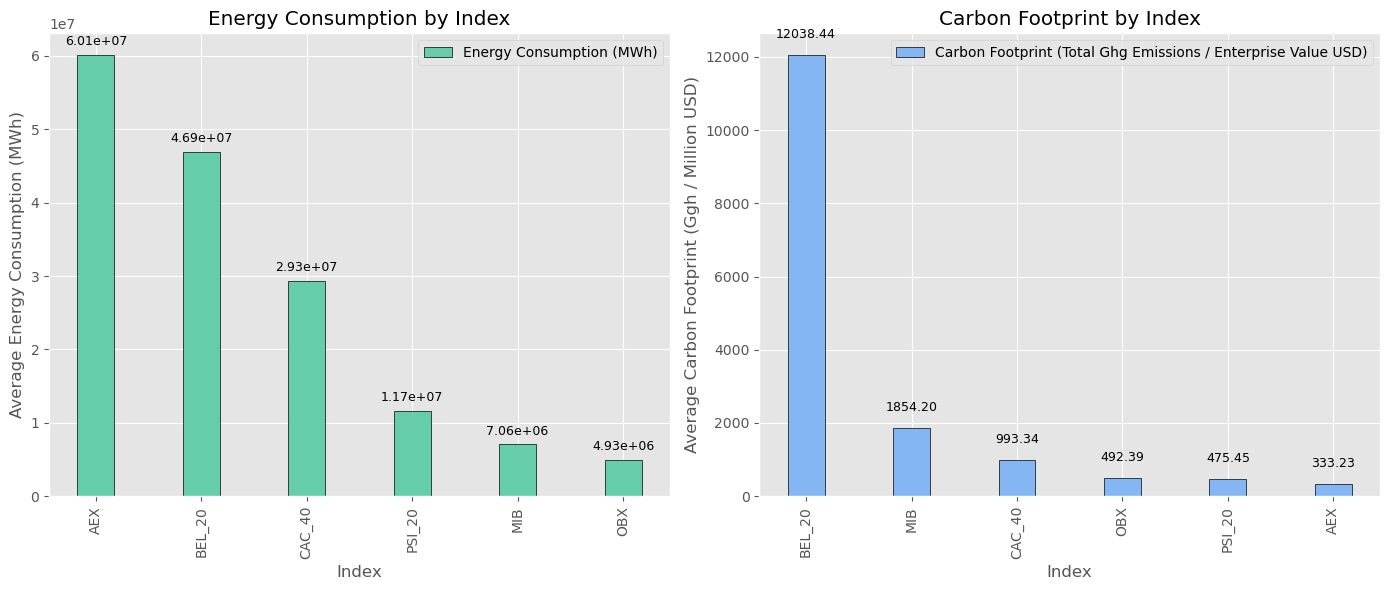

In [21]:
### ENERGY CONSUMPTION
# Group data by 'Index', calculate the average energy consumption, and filter out the 'ISEQ' index
avg_energy_consumption = df_final[df_final['Index'] != 'ISEQ'].groupby('Index').agg(
    {'Total Energy Consumption In Mwh': 'mean'}
).reset_index()

# Sort descending by the correct column
avg_energy_consumption = avg_energy_consumption.sort_values(by='Total Energy Consumption In Mwh', ascending=False)

### CARBON FOOTPRINT
# Group data by 'Index', calculate the average carbon footprint, and filter out the 'ISEQ' index
avg_carbon_footprint = df_final[df_final['Index'] != 'ISEQ'].groupby('Index').agg(
    {'Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd': 'mean'}
).reset_index()

# Sort descending
avg_carbon_footprint = avg_carbon_footprint.sort_values(by='Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd', ascending=False)

# PLOTS
# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Width and positions
bar_width = 0.35
indexes = np.arange(len(avg_energy_consumption['Index']))

### ENERGY CONSUMPTION
# Plot 1st subplot
bars1 = ax1.bar(indexes, avg_energy_consumption['Total Energy Consumption In Mwh'], 
                bar_width, label='Energy Consumption (MWh)', color='#66CDAA', edgecolor='black')
ax1.set_xlabel('Index')
ax1.set_ylabel('Average Energy Consumption (MWh)')
ax1.set_title('Energy Consumption by Index')
ax1.set_xticks(indexes)
ax1.set_xticklabels(avg_energy_consumption['Index'], rotation=90)
ax1.legend()

# Data Labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.2e}',  # Use scientific notation
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center', va='bottom',
                 textcoords="offset points", xytext=(0,5), fontsize=9)

### CARBON FOOTPRINT
# Plot 2nd subplot
bars2 = ax2.bar(indexes, avg_carbon_footprint['Carbon Footprint (Total Ghg Emissions / Enterprise Value)_In_Usd'], 
                bar_width, label='Carbon Footprint (Total Ghg Emissions / Enterprise Value USD)', color='#84b6f4', edgecolor='black')
ax2.set_xlabel('Index')
ax2.set_ylabel('Average Carbon Footprint (Ggh / Million USD)')
ax2.set_title('Carbon Footprint by Index')
ax2.set_xticks(indexes)
ax2.set_xticklabels(avg_carbon_footprint['Index'], rotation=90)
ax2.legend()

# Convert numbers to MTon and add Data Labels
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}',  # Use the actual value as the unit is already MTon / Million USD
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center', va='bottom',
                 textcoords="offset points", xytext=(0,10), fontsize=9)

plt.tight_layout()
plt.show()


The side-by-side plots compare the **average energy consumption** and **carbon footprint** of different indexes.

- **Energy Consumption:** On the left plot, energy consumption is measured in megawatt-hours (MWh). The **AEX** index has the highest average energy consumption, showing a value of approximately **6.01 x 10^7 MWh**, which indicates that companies listed under the **AEX** index, on average, consume more energy compared to those listed under other indexes. The next highest is the **BEL-20**, with an average consumption of around **4.69 x 10^7 MWh**. These figures point to potential areas for energy optimization and sustainable energy solutions.

- **Carbon Footprint:** On the right plot, the carbon footprint is presented in metric tons (presumably) per million USD. It's crucial to note the scale on the Y-axis; the highest value for **BEL-20** stands at approximately **12038.44 metric tons per million USD**, which is an order of magnitude higher than any other index, indicating a much greater carbon footprint relative to their enterprise value. The **MIB** is the next highest, with a value of around **1854.20**, which is significantly lower than **BEL-20** but still considerable.

The plots show that the **BEL-20** Index has an exceptionally high carbon footprint compared to other indices, possibly due to the nature of the constituent industries, their operational efficiencies or energy sources. There may also be data or scale inaccuracies in the visualisation.

These visualisations highlight the need for a dual focus on energy use and carbon emissions in corporate environmental reporting. High values in the graphs indicate the potential for indices to improve their sustainability by investing in greener practices. This information is valuable to investors and regulators seeking to promote sustainable corporate behaviour.

### Gender Diversity & Pay Gap by Index

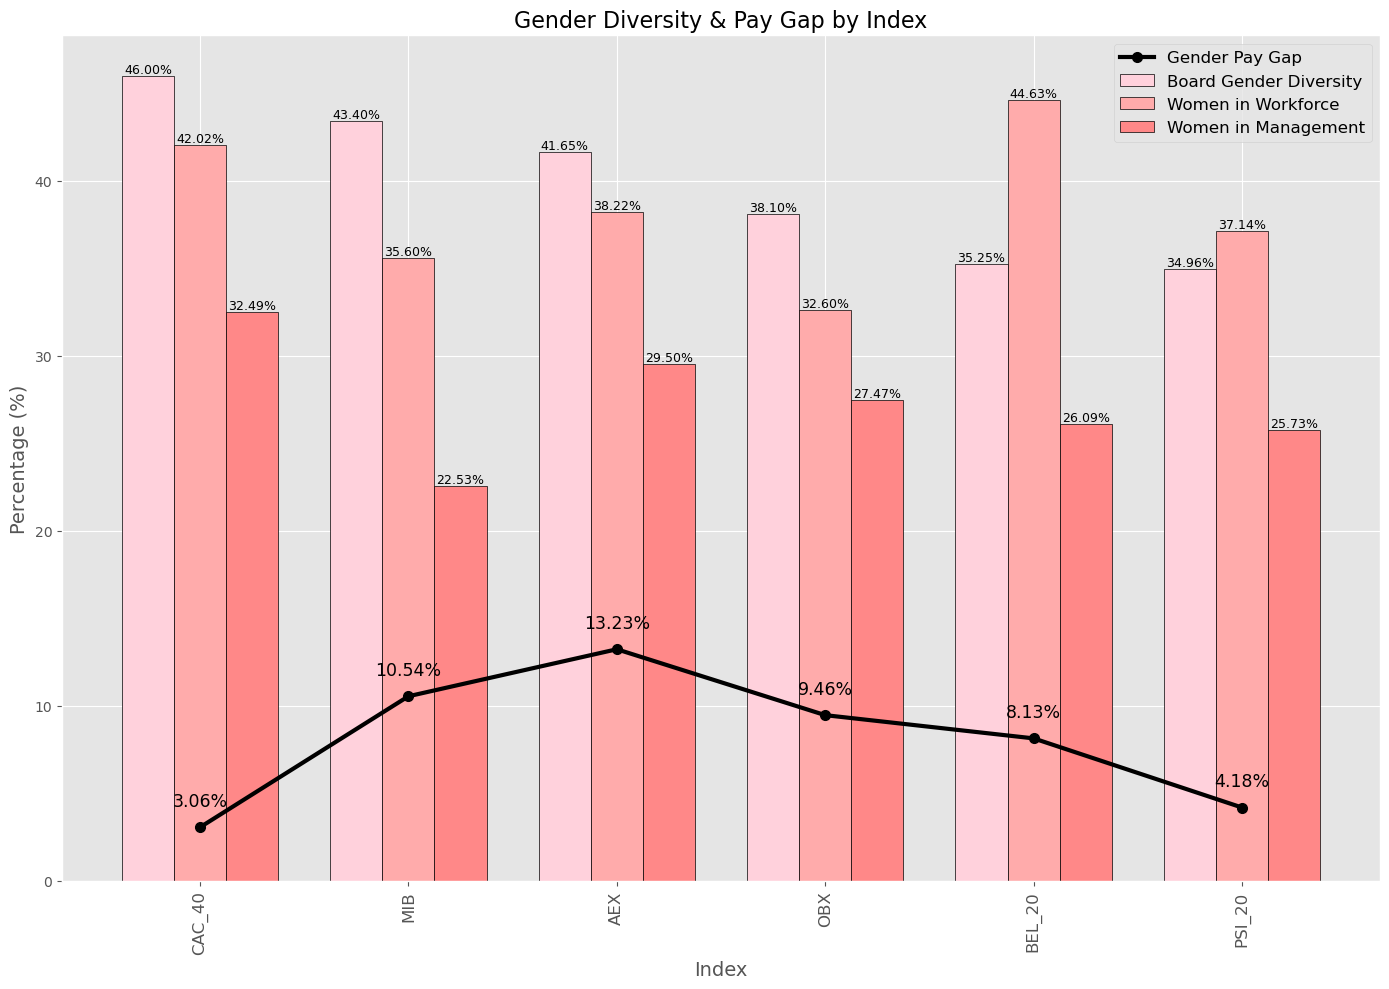

In [22]:
# Group data by 'Index', calculate the mean, and exclude 'ISEQ'
avg_gender_data = df_final[df_final['Index'] != 'ISEQ'].groupby('Index').agg({
    'Board Gender Diversity (Female Board Members / Total Board Members) In %': 'mean',
    'Share Of Women In Total Workforce In %': 'mean',
    'Share Of Women In Management Bodies In %': 'mean',
    'Gender Pay Gap In %': 'mean'  # Adding the new column to aggregate
}).reset_index()

# Transform the data into percentages
avg_gender_data['Board Gender Diversity %'] = avg_gender_data['Board Gender Diversity (Female Board Members / Total Board Members) In %'] * 100
avg_gender_data['Women in Workforce %'] = avg_gender_data['Share Of Women In Total Workforce In %'] * 100
avg_gender_data['Women in Management %'] = avg_gender_data['Share Of Women In Management Bodies In %'] * 100
avg_gender_data['Gender Pay Gap %'] = avg_gender_data['Gender Pay Gap In %']  * 100 

# Sort the bars within each index group
avg_gender_data.sort_values(by=['Board Gender Diversity %', 'Women in Workforce %', 'Women in Management %', 'Gender Pay Gap %'],
                            ascending=False, inplace=True)

indexes = np.arange(len(avg_gender_data['Index']))

# Plot
plt.figure(figsize=(14, 10))
plt.style.use('ggplot')
plt.bar(indexes - 0.25, avg_gender_data['Board Gender Diversity %'], 
        0.25, label='Board Gender Diversity', color='#FFD1DC', edgecolor='black')
plt.bar(indexes, avg_gender_data['Women in Workforce %'], 
        0.25, label='Women in Workforce', color='#FFABAB', edgecolor='black')
plt.bar(indexes + 0.25, avg_gender_data['Women in Management %'], 
        0.25, label='Women in Management', color='#FF8888', edgecolor='black')
plt.plot(indexes, avg_gender_data['Gender Pay Gap %'], color='black', marker='o', linestyle='-', linewidth=3, markersize=7, label='Gender Pay Gap')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Gender Diversity & Pay Gap by Index', fontsize=16)
plt.xticks(indexes, avg_gender_data['Index'], rotation=90, fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Data labels
for i, rect in enumerate(plt.gca().patches):
    plt.gca().text(rect.get_x() + rect.get_width() / 2, rect.get_height(), 
                   f'{rect.get_height():.2f}%', ha='center', va='bottom', fontsize=9, color='black')
    
# Data labels for line plot
for i, value in enumerate(avg_gender_data['Gender Pay Gap %']):
    plt.text(indexes[i], value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=12.5, color='black')

plt.show()



In this visual representation of gender diversity and pay gap by index, it's clear that while some indices have made progress in gender diversity in their workforce and management, the pay gap remains a critical issue.

We focus on the top three indices based on the combined factors of ****board gender diversity****, ****women in the workforce****, ****women in management**** and the ****gender pay gap****:

- **CAC-40** has the best score for gender diversity on the board at **46.00%**, indicating a progressive board composition. Its representation of women in the workforce and management is **32.49%** and **22.53%** respectively. However, it also has a significant gender pay gap of **3.06%**, indicating that despite a diverse board, pay equality is not yet fully realised.
- **MIB** has a notable gender diversity in its management with **43.40%** and in its workforce with **35.60%**. The gender pay gap here is slightly higher than in the **CAC-40** at **10.54%**, highlighting an area for potential improvement despite good representation.
- **AEX** has impressive gender diversity in management at **41.65%**, slightly lower than MIB, with **38.22%** of the workforce being female. However, with a gender pay gap of **13.23%**, it shows a disparity in pay, even with good representation in senior roles.
- **OBX's** data shows a lower level of gender diversity, with **38.10%** of the workforce and **27.47%** in senior roles being female. The pay gap is reported at **9.46%**, suggesting that gender pay equity may be closer than some others, although there is room for improvement.
- **BEL-20** shows a lower presence of women both in the workforce and in management, at **35.25%** and **26.09%** respectively. However, it has a relatively low gender pay gap of **8.13%**, suggesting that the gender pay gap is not as pronounced.
- While **PSI-20** has the lowest gender diversity on the board at **34.96%** and women in management at **25.73%**, it stands out with the lowest gender pay gap at **4.18%**. This suggests a more equitable pay structure, despite the lower representation of women in the higher echelons.

This plot shows that having more women in top jobs doesn’t guarantee they’re paid equally to men. Even with a lot of women leaders, **CAC-40** and **AEX** still pay women less compared to men. 

However, **PSI-20** has fewer women at the top but they’re closer to pay equality. This shows that the issue of gender equality is complicated, and we need to work carefully to make sure women are both well-represented and fairly paid.

### Employees with Disabilities by Index

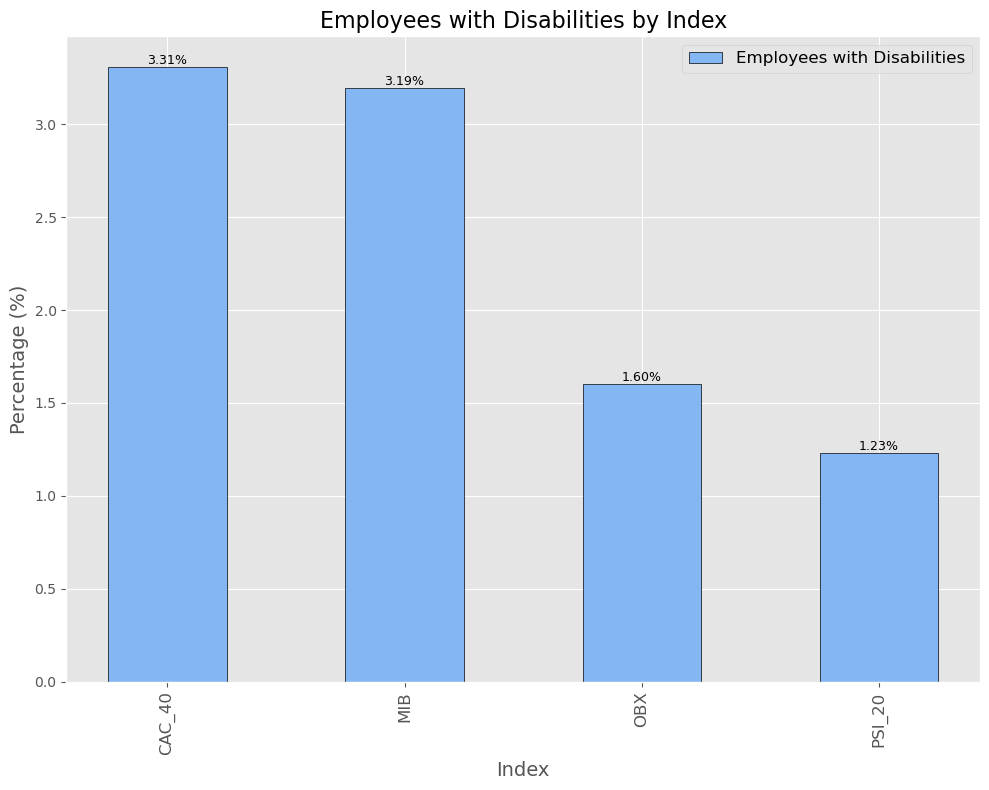

In [18]:
# Group data by 'Index', calculate the mean for 'Rate Of Employees With Disabilities In %', and exclude 'ISEQ'
avg_disability_data = df_final[df_final['Index'] != 'ISEQ'].groupby('Index').agg({
    'Rate Of Employees With Disabilities In %': 'mean'
}).reset_index()

# Convert this to a percentage
avg_disability_data['Rate Of Employees With Disabilities %'] = avg_disability_data['Rate Of Employees With Disabilities In %'] * 100

# Filter out 'AEX' and 'BEL_20' if they have no values
avg_disability_data_filtered = avg_disability_data[~avg_disability_data['Index'].isin(['AEX', 'BEL_20'])]

# Sort in descending order
avg_disability_data_sorted = avg_disability_data_filtered.sort_values(by='Rate Of Employees With Disabilities %', ascending=False)

indexes = np.arange(len(avg_disability_data_sorted['Index']))

# Plot
plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
plt.bar(indexes, avg_disability_data_sorted['Rate Of Employees With Disabilities %'],
        0.5, label='Employees with Disabilities', color='#84b6f4', edgecolor='black')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Employees with Disabilities by Index', fontsize=16)
plt.xticks(indexes, avg_disability_data_sorted['Index'], rotation=90, fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Data Labels
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height,
                   f'{height:.2f}%', ha='center', va='bottom', fontsize=9, color='black')
    
plt.show()


The plot shows the percentage of employees with disabilities according to different indexes, comparing the **MIB**, the **CAC-40**, the **OBX** and the **PSI-20**. 

Notably, the **AEX** and **BEL-20** indexes are not included in this visualisation. The exclusion of the **AEX** and **BEL-20** is specifically due to the fact that these indexes reportedly have no employees with disabilities, which corresponds to a **rate** of **0%**. As such, they have been excluded from the plot in order to focus only on those indexes where there is a measurable proportion of employees with disabilities. 

The visualisation effectively conveys the relative differences between the indexes shown, with **CAC_40** having the **highest rate** at **3.31%** and **PSI-20** the **lowest** at **1.23%**.

### Calculation of the most responsible ESG Index in terms of Enviromental & Social Scores

In [23]:
# Save the resulted values in dictionaries
energy_consumptions = {'AEX': 60100000, 'BEL-20': 46900000, 'CAC-40': 29300000, 'PSI-20': 11700000,'MIB': 7060000, 'OBX': 4930000}

carbon_footprints = {'MIB': 1854.20, 'BEL-20': 12038.44, 'AEX': 333.23, 'CAC-40': 993.34, 'PSI-20': 475.45,'OBX': 492.39}

gender_diversity = {
    'Board Gender Diversity': {'CAC-40': 46.00, 'MIB': 43.40, 'OBX': 38.10, 'PSI-20': 34.96, 'AEX': 41.65, 'BEL-20': 35.25},
    'Women in Workforce': {'CAC-40': 42.02, 'MIB': 35.60, 'OBX': 32.60, 'PSI-20': 37.14, 'AEX': 38.22, 'BEL-20': 44.63},
    'Women in Management': {'CAC-40': 32.49, 'MIB': 22.53, 'OBX': 27.47, 'PSI-20': 25.73, 'AEX': 29.50, 'BEL-20': 26.09},
}

gender_pay_gap = {'CAC-40': 3.06, 'MIB': 10.54, 'OBX': 9.46, 'PSI-20': 4.18, 'AEX': 13.23, 'BEL-20': 8.13}

disabilities = {'MIB': 3.31, 'CAC-40': 3.19, 'OBX': 1.60, 'PSI-20': 1.23}



# Calculate environmental and social scores
def calculate_scores(energy, carbon, diversity, pay_gap, disabilities):
    # Calculate the environmental scores (lower values are better)
    min_energy = min(energy.values())
    min_carbon = min(carbon.values())
    env_scores = {k: ((min_energy / v) * 50 + (min_carbon / carbon[k]) * 50) for k, v in energy.items()}
    
    # Calculate the social scores (higher values are better)
    max_diversity = {category: max(values.values()) for category, values in diversity.items()}
    max_pay_gap = max(pay_gap.values())
    max_disabilities = max(disabilities.values())
    
    # Normalize gender diversity and pay gap scores between 0 and 100
    social_scores = {}
    for index in energy.keys():
        diversity_scores = sum((value / max_diversity['Board Gender Diversity']) * 100 for category, value in diversity['Board Gender Diversity'].items() if category == index)
        pay_gap_score = (pay_gap.get(index, 0) / max_pay_gap) * 100
        disability_score = (disabilities.get(index, 0) / max_disabilities) * 100
        
        # Average the diversity and pay gap scores, then average with disability score
        social_scores[index] = (diversity_scores + pay_gap_score + disability_score) / 3
    
    # Combine environmental and social scores for overall score
    overall_scores = {k: (env_scores[k] + social_scores[k]) / 2 for k in env_scores}
    
    return env_scores, social_scores, overall_scores

# Execute score calculation
env_scores, social_scores, overall_scores = calculate_scores(
    energy_consumptions,
    carbon_footprints,
    gender_diversity,
    gender_pay_gap,
    disabilities
)

# Print results
print("Environmental Scores:")
for company, score in env_scores.items():
    print(f"{company}: {score:.2f}")

print("\nSocial Scores:")
for company, score in social_scores.items():
    print(f"{company}: {score:.2f}")

print("\nOverall Scores:")
for company, score in overall_scores.items():
    print(f"{company}: {score:.2f}")


Environmental Scores:
AEX: 54.10
BEL-20: 6.64
CAC-40: 25.19
PSI-20: 56.11
MIB: 43.90
OBX: 83.84

Social Scores:
AEX: 63.51
BEL-20: 46.03
CAC-40: 73.17
PSI-20: 48.25
MIB: 91.34
OBX: 67.56

Overall Scores:
AEX: 58.81
BEL-20: 26.33
CAC-40: 49.18
PSI-20: 52.18
MIB: 67.62
OBX: 75.70


## Question 2 | Conclusion


Based on the updated environmental and social responsibility scores for each index:

**Environmental Responsibility:**

- The **OBX** index has the highest environmental responsibility score at **83.84**, indicating strong performance in terms of environmental sustainability measures.
- The **PSI-20** also scores well with a value of **56.11**, showing considerable attention to environmental factors.
- The other indices show varied performance, with the **AEX** scoring **54.10** and the **CAC-40** at **25.19**, indicating room for improvement in their environmental initiatives.

**Social Responsibility:**

- The **MIB** index leads in social responsibility with a high score of **91.34**, which reflects its robust initiatives towards social factors like gender diversity, fair employment practices, and inclusion.
- The **CAC-40** follows with a score of **73.17**, also indicating strong performance in social criteria.
- The scores for other indices like the **AEX** at **63.51** and the **OBX** at **67.56** show good, but not exceptional, social performance.

**Overall Conclusion:**

- The **OBX** index demonstrates a strong focus on environmental sustainability, though its social scores, while good, are not the highest.
- The **CAC-40** and **MIB** indices show significant strengths in social responsibility, with the **MIB** also scoring well overall, suggesting a balanced approach to both environmental and social responsibility.
- The **AEX**, while performing moderately in both categories, still shows a stronger inclination towards social responsibility with room for environmental improvement.
- The **PSI-20** and **BEL-20** indices show mixed results, with a need for stronger focus in both categories to improve their overall scores.

Investors focused on environmental sustainability might lean towards the **OBX** index, whereas those prioritizing social responsibility might find the **MIB** or **CAC-40** more appealing. 

For a balanced portfolio in both respects, the **MIB** index appears to be the most comprehensive choice.

## Question 3 | How do the main European companies that have a great ESG rating behave compared to those that do not, measured through key financial ratios such as ROA, ROE, ROIC?  

The datasets from the question have been used, after being modified and adapted

In [24]:
# Reset the index of result_df2 and update the 'ESG leader' column
result_df.reset_index(drop=True, inplace=True)

# Assign 'Yes' to the first 5 rows and 'No' to the rest in the 'ESG leader' column
result_df['ESG leader'] = ['Yes' if i < 5 else 'No' for i in range(len(result_df))]

# Add a new column 'Topic' with the value "Carbon footprint" to result_df2
result_df['Topic'] = "Carbon footprint"

# Select only the 'Name', 'ESG leader', and 'Topic' columns in result_df2
result_df = result_df[["Name", "ESG leader", "Topic"]]

# Reset the index of result_df2 after the previous operations
result_df.reset_index(drop=True, inplace=True)

# Perform the 'Yes'/'No' assignment to the 'ESG leader' column again
result_df['ESG leader'] = ['Yes' if i < 5 else 'No' for i in range(len(result_df))]

# Merge df and result_df2 based on the 'Name' column
merged_df = pd.merge(df, result_df, on='Name', how='inner')

# Preserve only the 'Name', 'ESG leader', 'Topic', 'Roa', 'Roe', and 'Roic' columns in the merged DataFrame
carbon_footprint_df = merged_df[["Name", "ESG leader", "Topic", 'Roa', 'Roe', 'Roic']]

carbon_footprint_df.head(4)

Name ESG leader             Topic  Roa   Roe  Roic
0  Stellantis Nv        Yes  Carbon footprint  7.4  24.1  19.7
1     Stellantis        Yes  Carbon footprint  7.4  24.1  19.7
2         Prosus         No  Carbon footprint  NaN  26.0   NaN
3      Shell Plc        Yes  Carbon footprint  5.2  10.3  12.4

In [25]:

# Reset the index of result_df2 and update the 'ESG leader' column
result_df2.reset_index(drop=True, inplace=True)

# Assign 'Yes' to the first 5 rows and 'No' to the rest in the 'ESG leader' column
result_df2['ESG leader'] = ['Yes' if i < 5 else 'No' for i in range(len(result_df2))]

# Add a new column 'Topic' with the value "Carbon footprint" to result_df2
result_df2['Topic'] = "Energy consumption"

# Select only the 'Name', 'ESG leader', and 'Topic' columns in result_df2
result_df2 = result_df2[["Name", "ESG leader", "Topic"]]

# Reset the index of result_df2 after the previous operations
result_df2.reset_index(drop=True, inplace=True)

# Perform the 'Yes'/'No' assignment to the 'ESG leader' column again
result_df2['ESG leader'] = ['Yes' if i < 5 else 'No' for i in range(len(result_df2))]

# Merge df and result_df2 based on the 'Name' column
emissions = pd.merge(df, result_df2, on='Name', how='inner')

# Preserve only the 'Name', 'ESG leader', 'Topic', 'Roa', 'Roe', and 'Roic' columns in the merged DataFrame
energy_consumption_df = emissions[["Name", "ESG leader", "Topic", 'Roa', 'Roe', 'Roic']]

energy_consumption_df.head(4)

Name ESG leader               Topic   Roa  \
0                      Asml Holding         No  Energy consumption  14.8   
1  Be Semiconductor Industries N.V.         No  Energy consumption  13.1   
2                           Kpn Kon        Yes  Energy consumption   7.0   
3                          Nn Group         No  Energy consumption   0.8   

    Roe  Roic  
0  70.4  48.7  
1  33.7  28.3  
2  23.0  12.9  
3   6.1   7.4

In [29]:
# Append of the data
df_esg_metrics = pd.concat([energy_consumption_df, carbon_footprint_df], ignore_index=True)

# Verify the shape
df_esg_metrics.shape # Now its 20 so it works

(20, 6)

First lets visualize this performance

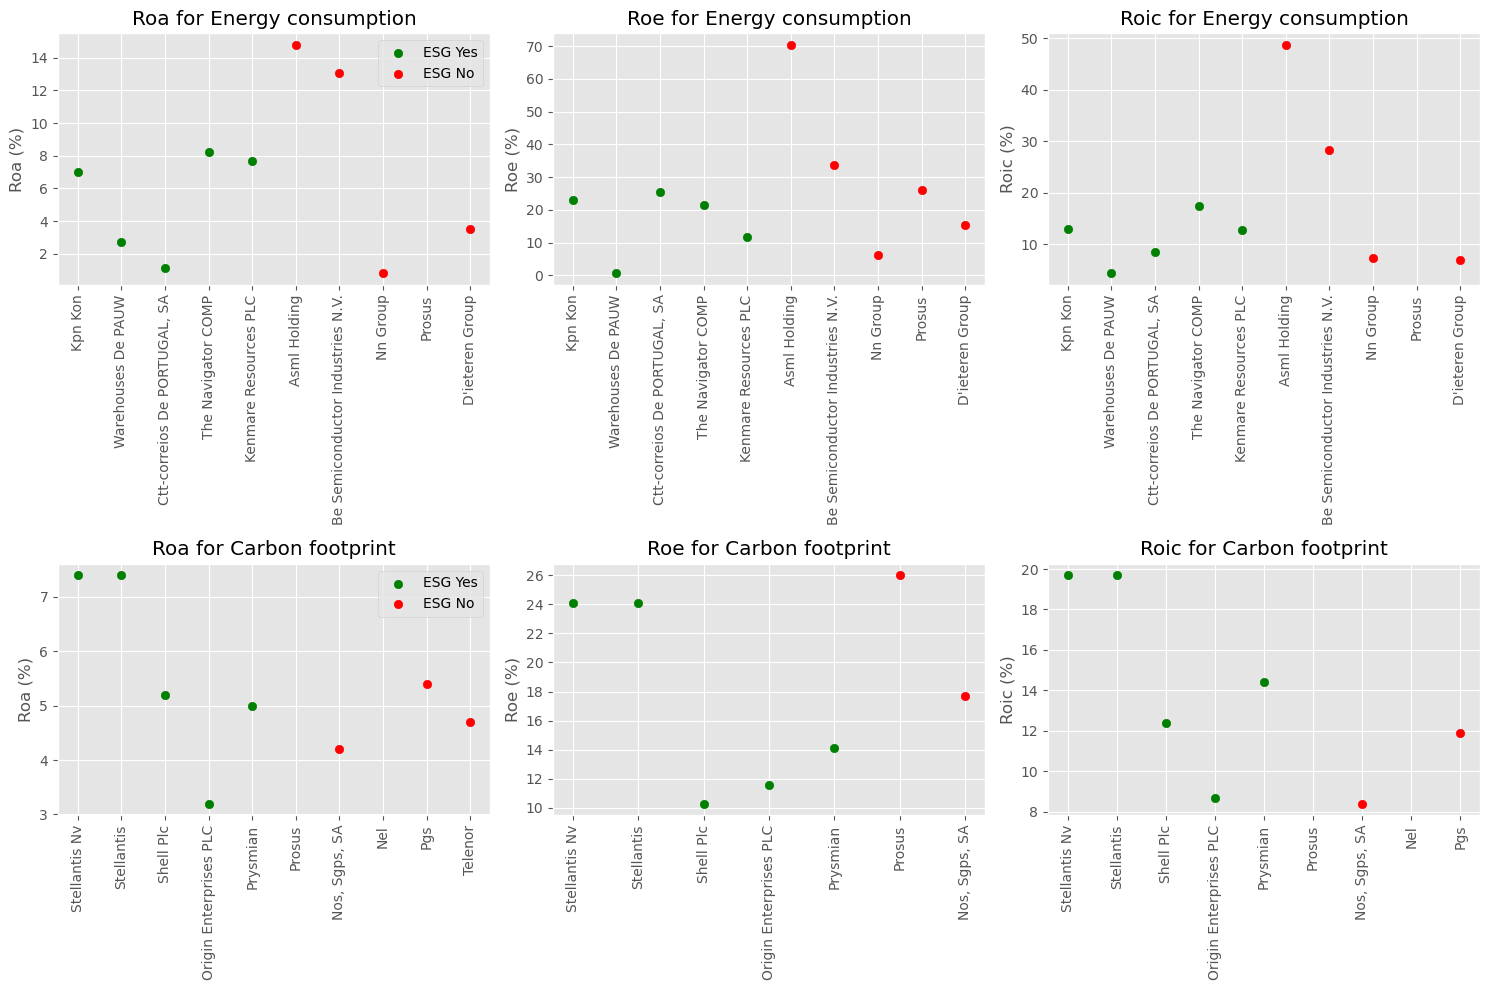

In [30]:
# Size of the figure
plt.figure(figsize=(15, 10))

# Unique "topics" of the DataFrame
unique_topics = df_esg_metrics['Topic'].unique()

# Number of graphics, 3 per topic
num_plots = 3

# Iterate on each topic and create graphs for ROA, ROE and ROIC
for i, topic in enumerate(unique_topics, 1):
     
     # Filter data by topic
     topic_data = df_esg_metrics[df_esg_metrics['Topic'] == topic]

     for j, measure in enumerate(['Roa', 'Roe', 'Roic'], start=1):
         plt.subplot(2, num_plots, (i-1) * num_plots + j)
         # Filter by ESG leader 'Yes' and 'No'
         for esg_status, color in zip(['Yes', 'No'], ['green', 'red']):
             subset = topic_data[topic_data['ESG leader'] == esg_status]
             plt.scatter(subset['Name'], subset[measure], color=color, label=f'ESG {esg_status}')

         plt.title(f'{measure} for {topic}')
         plt.xticks(rotation=90)
         plt.ylabel(f'{measure} (%)')
         if j == 1: # Only add the legend to the first graph of each row
             plt.legend()

plt.tight_layout()
plt.show()

Based on the visual representation of the plots, here's an interpretation of the behavior of main European companies with great ESG (Environmental, Social, Governance) ratings compared to those without, through the financial ratios ROA (Return on Assets), ROE (Return on Equity), and ROIC (Return on Invested Capital):

- **ROA (Return on Assets)**: This ratio indicates how efficiently a company's management is using its assets to generate earnings. The plots show a mixed behavior; for 'Energy consumption', companies with high ESG ratings (green dots) generally exhibit a variety of ROA values, both high and low. For 'Carbon footprint', the distribution is similar, but there seems to be less variance in the ROA values for ESG leaders.

- **ROE (Return on Equity)**: This measure reflects the ability of a company to generate profits from its shareholders' equity. In the 'Energy consumption' topic, companies with high ESG ratings do not necessarily have the highest ROE; there is a mix, with some high-ESG companies showing higher ROE and some showing lower. The 'Carbon footprint' topic also shows a mixed pattern, with no clear distinction between ESG leaders and non-leaders.

- **ROIC (Return on Invested Capital)**: This ratio measures how well a company is using its capital to generate returns. In both topics, companies with high ESG ratings (green dots) are spread across the range of ROIC values. There isn't a consistent trend that shows ESG leaders always have a higher or lower ROIC compared to their non-ESG counterparts.

**Overall Interpretation**:
In general, we can not see a consistent pattern that shows companies with high ESG ratings consistently outperform those without in terms of ROA, ROE, and ROIC. The performance varies across companies and does not show a clear correlation with ESG ratings in this particular set of data. This suggests that while ESG factors are important for a company's long-term sustainability and risk management, they don't always directly translate to superior financial performance in terms of these ratios, at least not in a uniform way across different companies and industries.

Thats why we decide to perform an anova test:

In [31]:
# Delete rows with NaN values in ROE ROA ROIC
df_esg_metrics_clean_na = df_esg_metrics.dropna(subset=['Roa', 'Roe', 'Roic'])

# Prepare ANOVA results
anova_results = {}

# Perform ANOVA for each of the financial ratios
for ratio in ['Roa', 'Roe', 'Roic']:
     # Separate the data into two groups: one for ESG 'Yes' and another for ESG 'No'
     group_yes = df_esg_metrics_clean_na[df_esg_metrics_clean_na['ESG leader'] == 'Yes'][ratio]
     group_no = df_esg_metrics_clean_na[df_esg_metrics_clean_na['ESG leader'] == 'No'][ratio]
    
     # Perform the ANOVA
     f_value, p_value = stats.f_oneway(group_yes, group_no)
    
     # Store the results
     anova_results[ratio] = {'F-Value': f_value, 'P-Value': p_value}

anova_df = pd.DataFrame(anova_results).T
anova_df['Significance'] = anova_df['P-Value'].apply(lambda p: "Yes" if p < 0.05 else "No")
anova_df

F-Value   P-Value Significance
Roa   0.659227  0.431450           No
Roe   1.969846  0.183898           No
Roic  1.292208  0.276162           No

For the different metrics:

- **ROA (Return on Assets)**: With a P-Value of 0.431, there's no statistical evidence to suggest a difference in asset efficiency between the two groups. Both high and low ESG-rated companies appear to convert their assets into earnings at a similar rate.

- **ROE (Return on Equity)**: The P-Value here is 0.184, which also indicates that there is no significant statistical difference in how effectively each group of companies generates profit from shareholders' equity. It implies that a higher ESG rating does not necessarily correlate with a higher return on equity.

- **ROIC (Return on Invested Capital)**: The P-Value of 0.276 suggests that there's no significant difference in the return on invested capital between companies with high and low ESG ratings. This ratio measures how well a company is using its capital to generate returns, and the results imply that ESG factors do not have a statistically significant impact on this measure.

## Question 3 | Conclusion

In summary, based on this dataset and the ANOVA tests performed, there is no statistical evidence to support the idea that European companies with high ESG ratings perform differently in terms of ROA, ROE, and ROIC when compared to those with lower ESG ratings. It indicates that, at least in terms of these financial ratios, ESG leadership status does not lead to different financial performance outcomes. 

This could imply that other factors may be influencing the financial performance of these companies, or that the benefits of high ESG ratings are not captured solely by these financial ratios.

In [ ]:
# meter todo lo de maria db

### Export final df

In [25]:
#df.to_csv(f'../data/merged_data_stage4/group8_delivery_data_stage4.csv', index=False)